**Введение в нейронные сети и PyTorch**

Сборная Москвы по ИИ

---

В этом ноутбуке мы:
- Познакомимся с основами PyTorch: тензоры, autograd
- Научимся строить нейронные сети
- Напишем полный цикл обучения
- Обучим модель на реальных данных (FashionMNIST)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F

print(f'PyTorch version: {torch.__version__}')

---

**Часть 1. Тензоры в PyTorch**

Тензор — это основная структура данных в PyTorch. По сути это многомерный массив, аналог `np.ndarray`, но с поддержкой GPU и автоматического дифференцирования.

**Создание тензоров**

In [ ]:
# Из списка
a = torch.tensor([1, 2, 3])
print(f'a = {a}, shape = {a.shape}, dtype = {a.dtype}')

# Нули, единицы, случайные
zeros = torch.zeros(2, 3)
ones = torch.ones(2, 3)
rand = torch.randn(2, 3)  # нормальное распределение

print(f'\nzeros:\n{zeros}')
print(f'\nones:\n{ones}')
print(f'\nrandn:\n{rand}')

**Связь с NumPy**

Тензоры легко конвертируются в NumPy и обратно. Важно: при конвертации они **разделяют память** (если тензор на CPU).

In [ ]:
# NumPy -> Tensor
np_array = np.array([1.0, 2.0, 3.0])
tensor_from_np = torch.from_numpy(np_array)
print(f'NumPy: {np_array} -> Tensor: {tensor_from_np}')

# Tensor -> NumPy
back_to_np = tensor_from_np.numpy()
print(f'Tensor -> NumPy: {back_to_np}')

# Общая память!
np_array[0] = 999
print(f'\nПосле изменения np_array[0] = 999:')
print(f'NumPy: {np_array}')
print(f'Tensor: {tensor_from_np}  <-- тоже изменился!')

---

**Вопрос 1.** Мы увидели, что `torch.from_numpy()` создаёт тензор, который разделяет память с numpy-массивом. Почему это важно знать? В каких ситуациях это может привести к багам?

<details>
<summary><b>Ответ</b></summary>
<br>

Если изменить numpy-массив после создания тензора — **тензор тоже изменится** (и наоборот). Это может привести к неочевидным багам, если вы случайно модифицируете исходные данные, думая, что работаете с независимой копией.

Чтобы создать **независимую копию**, используйте:

```python
# Разделяет память (опасно):
tensor = torch.from_numpy(np_array)

# Создаёт независимую копию (безопасно):
tensor = torch.tensor(np_array)
```

Общая память — это фича для экономии памяти и скорости, но пользоваться ей нужно осознанно.

</details>

**Операции над тензорами**

Почти все операции аналогичны NumPy:

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor([4.0, 5.0, 6.0])

# Поэлементные операции
print(f'x + y = {x + y}')
print(f'x * y = {x * y}')
print(f'x ** 2 = {x ** 2}')

# Матричные операции
A = torch.randn(3, 4)
B = torch.randn(4, 2)
C = A @ B  # матричное умножение
print(f'\nA.shape = {A.shape}, B.shape = {B.shape}, (A @ B).shape = {C.shape}')

# Изменение формы
t = torch.arange(12)
print(f'\nt = {t}')
print(f't.reshape(3, 4) =\n{t.reshape(3, 4)}')
print(f't.reshape(2, 2, 3) =\n{t.reshape(2, 2, 3)}')

**GPU / Device**

Одно из главных преимуществ PyTorch — вычисления на GPU. Перенос тензоров между CPU и GPU делается через `.to(device)`.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

# Перенос тензора на device
t = torch.randn(3, 3).to(device)
print(f'Тензор на {t.device}')

---

**Вопрос 2.** Что произойдёт, если попытаться сложить тензор на GPU с тензором на CPU?

<details>
<summary><b>Ответ</b></summary>
<br>

PyTorch выдаст **ошибку**: все тензоры, участвующие в одной операции, должны находиться на **одном устройстве**.

```python
a = torch.tensor([1.0]).to('cuda')
b = torch.tensor([2.0])  # на CPU
c = a + b  # RuntimeError!
```

Нужно явно переносить тензоры через `.to(device)`. В тренировочном цикле это делается так:

```python
images, labels = images.to(device), labels.to(device)
```

Это частая ошибка у начинающих — забыть перенести данные или модель на GPU.

</details>

---

**Часть 2. Autograd — автоматическое дифференцирование**

Autograd — это механизм автоматического вычисления градиентов. Именно он делает возможным обучение нейросетей через backpropagation.

Если у тензора `requires_grad=True`, PyTorch будет отслеживать все операции с ним и сможет автоматически вычислить градиенты.

In [ ]:
# Создаём тензор с отслеживанием градиентов
x = torch.tensor([2.0, 3.0], requires_grad=True)

# Вычисляем функцию: y = x^2 + 3x
y = x ** 2 + 3 * x

# Для вызова .backward() нужен скаляр — суммируем
loss = y.sum()
print(f'x = {x}')
print(f'y = x^2 + 3x = {y}')
print(f'loss = sum(y) = {loss}')

# Обратный проход — считаем градиенты
loss.backward()

# dy/dx = 2x + 3
print(f'\nГрадиент x.grad = {x.grad}')
print(f'Ожидаемый (2x+3): {2 * x.detach() + 3}')

**Важные моменты:**
- `.backward()` — запускает обратное распространение и вычисляет градиенты
- `.grad` — хранит вычисленные градиенты
- `.detach()` — создаёт копию тензора без отслеживания градиентов
- `torch.no_grad()` — контекстный менеджер, отключающий подсчёт градиентов (экономит память)

In [ ]:
# torch.no_grad() — используется при валидации / инференсе
x = torch.tensor([1.0], requires_grad=True)

with torch.no_grad():
    y = x * 2
    print(f'requires_grad внутри no_grad: {y.requires_grad}')  # False

y_outside = x * 2
print(f'requires_grad вне no_grad: {y_outside.requires_grad}')  # True

---

**Часть 3. Строим нейронную сеть**

Главная абстракция в PyTorch — `torch.nn.Module`. Каждая модель, каждый слой — это модуль.

Цикл обучения нейросети состоит из 4 шагов:
1. **Forward pass** — прямой проход, получаем предсказания
2. **Loss** — считаем функцию потерь
3. **Backward pass** — обратный проход, считаем градиенты
4. **Optimizer step** — обновляем веса

```python
for epoch in range(num_epochs):
    y_pred = model(x)               # forward pass
    loss = loss_function(y_pred, y)  # loss
    loss.backward()                  # backward pass
    optimizer.step()                 # обновляем веса
    optimizer.zero_grad()            # зануляем градиенты
```

**Слои (`torch.nn`)**

Основные слои:
- `nn.Linear(in_features, out_features)` — полносвязный слой
- `nn.ReLU()`, `nn.Sigmoid()`, `nn.Tanh()` — функции активации
- `nn.Flatten()` — "разворачивает" тензор в вектор
- `nn.Dropout(p)` — регуляризация (случайно зануляет нейроны)
- `nn.BatchNorm1d(num_features)` — нормализация батча

**Функции потерь:**
- `nn.CrossEntropyLoss()` — многоклассовая классификация (принимает **логиты**, не вероятности!)
- `nn.BCEWithLogitsLoss()` — бинарная классификация
- `nn.MSELoss()` — регрессия

**Оптимизаторы (`torch.optim`):**
- `torch.optim.SGD` — стохастический градиентный спуск
- `torch.optim.Adam` — адаптивный метод (хороший дефолтный выбор)

---

**Вопрос 3.** Зачем в цикле обучения вызывать `optimizer.zero_grad()`? Что произойдёт, если забыть это сделать?

<details>
<summary><b>Ответ</b></summary>
<br>

PyTorch **накапливает** (суммирует) градиенты при каждом вызове `.backward()`. Это значит, что если не обнулить `.grad` перед следующей итерацией, к текущим градиентам **прибавятся** градиенты от предыдущих батчей.

В результате обновление весов будет некорректным — модель не сойдётся или будет обучаться очень плохо.

Такое поведение сделано намеренно: иногда накопление градиентов полезно (например, при **gradient accumulation**, когда батч не помещается в память и его обрабатывают по частям). Но в стандартном цикле обучения градиенты **обязательно** нужно обнулять.

```python
optimizer.zero_grad()  # обнуляем градиенты
loss.backward()        # считаем новые градиенты
optimizer.step()       # обновляем веса
```

</details>

**Способ 1: `nn.Sequential`**

Самый простой способ — собрать сеть как последовательность слоёв:

In [12]:
# Простая нейросеть для FashionMNIST (10 классов, картинки 1x28x28)
model_sequential = nn.Sequential(
    nn.Flatten(),                  # 1*28*28 = 784
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

print(model_sequential)
print(f'\nКоличество параметров: {sum(p.numel() for p in model_sequential.parameters()):,}')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)

Количество параметров: 218,058


**Способ 2: наследование от `nn.Module`**

Более гибкий способ — написать свой класс. Нужно определить `__init__` (создаём слои) и `forward` (описываем проход данных через сеть).

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # логиты (без softmax!)
        return x


model = SimpleNet().to(device)
print(model)
print(f'\nКоличество параметров: {sum(p.numel() for p in model.parameters()):,}')

SimpleNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Количество параметров: 218,058


**Почему на выходе логиты, а не вероятности?**

`nn.CrossEntropyLoss` сам применяет softmax внутри. Это численно стабильнее, чем считать softmax отдельно.

---

**Часть 4. Обучаем нейросеть на FashionMNIST**

FashionMNIST — датасет из 70000 чёрно-белых картинок 28×28, разделённых на 10 классов одежды.

In [14]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Фикс SSL для macOS (если не скачивается)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**Загрузка данных**

PyTorch предоставляет удобные инструменты для работы с данными:
- `torchvision.datasets` — готовые датасеты
- `transforms` — преобразования (нормализация, аугментации)
- `DataLoader` — загрузчик данных, который формирует батчи и перемешивает данные

In [15]:
# Преобразование: конвертируем картинки в тензоры и нормализуем
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 1 канал (ч/б)
])

# Скачиваем данные
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Создаём DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Названия классов
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print(f'Train: {len(train_dataset)} изображений')
print(f'Test: {len(test_dataset)} изображений')

100%|██████████| 26421880/26421880 [00:08<00:00, 3240767.07it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265979.59it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3374723.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8710075.43it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train: 60000 изображений
Test: 10000 изображений


**Посмотрим на данные**

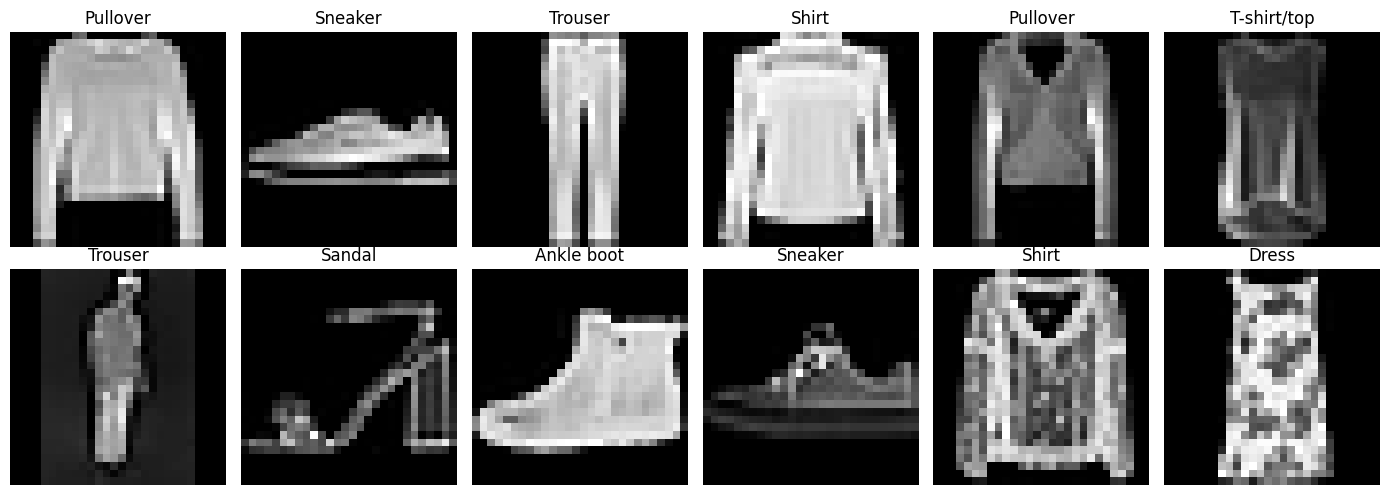

Размер батча изображений: torch.Size([64, 1, 28, 28])
Размер батча меток: torch.Size([64])


In [16]:
# Берём один батч для визуализации
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 6, figsize=(14, 5))
for i, ax in enumerate(axes.flat):
    # Денормализуем для отображения
    img = images[i].squeeze() * 0.5 + 0.5
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Размер батча изображений: {images.shape}')  # [batch, channels, height, width]
print(f'Размер батча меток: {labels.shape}')

**Создаём модель, лосс и оптимизатор**

In [17]:
model = SimpleNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**Пишем функции для обучения и оценки**

In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Одна эпоха обучения"""
    model.train()  # режим обучения (важно для Dropout, BatchNorm)
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Статистика
        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total


@torch.no_grad()  # отключаем подсчёт градиентов
def evaluate(model, loader, criterion, device):
    """Оценка модели на данных"""
    model.eval()  # режим оценки
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total

---

**Вопрос 4.** Чем отличаются `model.train()` и `model.eval()`? Почему важно не забывать переключать режимы?

<details>
<summary><b>Ответ</b></summary>
<br>

- `model.train()` — включает **режим обучения**: Dropout случайно зануляет нейроны, BatchNorm обновляет свои running-статистики (среднее и дисперсию)
- `model.eval()` — включает **режим оценки**: Dropout отключается (все нейроны работают), BatchNorm использует накопленные статистики

Если забыть вызвать `model.eval()` при оценке на тесте — результаты будут **нестабильными и заниженными** из-за работающего Dropout. Это одна из самых частых ошибок у новичков в PyTorch.

Аналогично, если забыть `model.train()` перед обучением — Dropout не будет работать и модель переобучится.

</details>

**Запускаем обучение!**

In [19]:
num_epochs = 10

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1:2d}/{num_epochs} | '
          f'Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | '
          f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}')

Epoch  1/10 | Train loss: 0.5022, acc: 0.8175 | Test loss: 0.4237, acc: 0.8426
Epoch  2/10 | Train loss: 0.3656, acc: 0.8657 | Test loss: 0.3995, acc: 0.8527
Epoch  3/10 | Train loss: 0.3323, acc: 0.8763 | Test loss: 0.3607, acc: 0.8730
Epoch  4/10 | Train loss: 0.3057, acc: 0.8878 | Test loss: 0.3722, acc: 0.8661
Epoch  5/10 | Train loss: 0.2888, acc: 0.8915 | Test loss: 0.3673, acc: 0.8711
Epoch  6/10 | Train loss: 0.2712, acc: 0.8989 | Test loss: 0.3429, acc: 0.8772
Epoch  7/10 | Train loss: 0.2580, acc: 0.9033 | Test loss: 0.3704, acc: 0.8667
Epoch  8/10 | Train loss: 0.2478, acc: 0.9082 | Test loss: 0.3386, acc: 0.8798
Epoch  9/10 | Train loss: 0.2350, acc: 0.9121 | Test loss: 0.3304, acc: 0.8838
Epoch 10/10 | Train loss: 0.2252, acc: 0.9157 | Test loss: 0.3474, acc: 0.8815


---

**Вопрос 5.** Допустим, на графиках мы видим, что train loss продолжает падать, а test loss начинает расти. Что это значит и как с этим бороться?

<details>
<summary><b>Ответ</b></summary>
<br>

Это классический признак **переобучения** (overfitting) — модель «запоминает» обучающие данные вместо того, чтобы находить общие закономерности.

Методы борьбы:
- **Dropout** — случайно зануляет часть нейронов при обучении, не даёт сети полагаться на конкретные нейроны
- **Ранняя остановка** (early stopping) — прекращаем обучение, когда test loss перестаёт улучшаться
- **Аугментация данных** — искусственно увеличиваем обучающую выборку (повороты, сдвиги, шум)
- **Регуляризация** — добавляем штраф за большие веса (`weight_decay` в оптимизаторе)
- **Уменьшение модели** — меньше слоёв / нейронов = меньше шансов переобучиться

</details>

**Графики обучения**

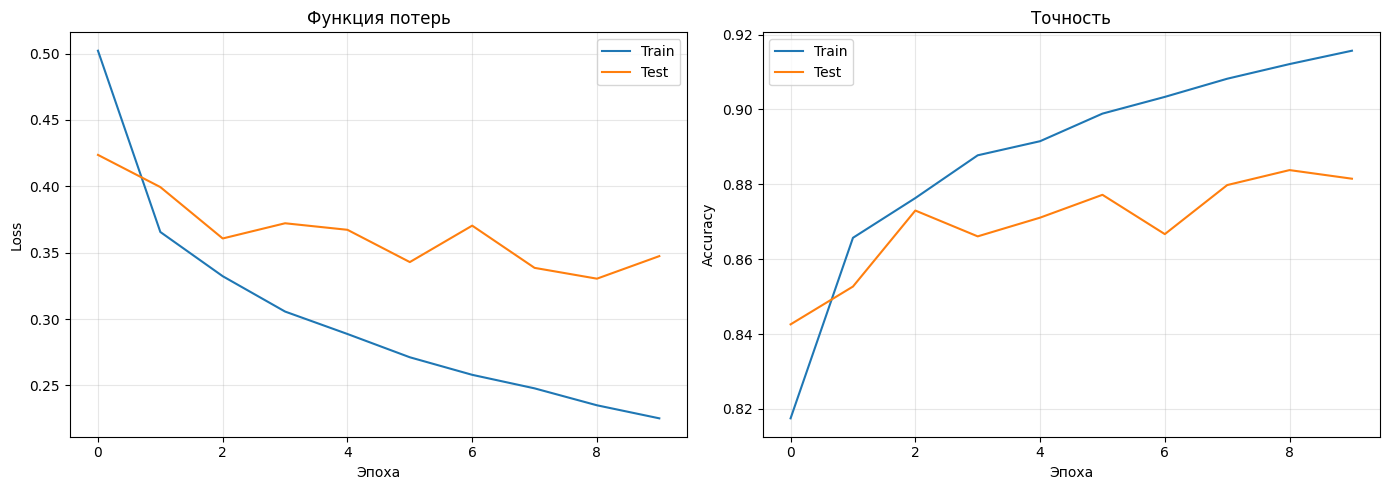

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('Функция потерь')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train')
ax2.plot(test_accs, label='Test')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('Точность')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Сохранение и загрузка модели**

Рекомендуется сохранять `state_dict` (словарь с весами), а не весь объект модели.

In [21]:
# Сохраняем
torch.save(model.state_dict(), 'best_model.pth')

# Загружаем
loaded_model = SimpleNet(num_classes=10).to(device)
loaded_model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))

# Проверяем
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, device)
print(f'Загруженная модель — Test accuracy: {test_acc:.4f}')

Загруженная модель — Test accuracy: 0.8815


---

**Итоги**

В этом ноутбуке мы разобрали:
- **Тензоры** — основная структура данных в PyTorch, аналог массивов NumPy с поддержкой GPU
- **Autograd** — автоматическое дифференцирование, основа для обучения нейросетей
- **nn.Module** — базовый класс для построения нейросетей
- **Цикл обучения** — forward → loss → backward → optimizer step
- **DataLoader** — удобная загрузка данных батчами
- **Сохранение/загрузка** моделей

Задание для практики — в отдельном ноутбуке `nn_intro_task.ipynb`.